Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


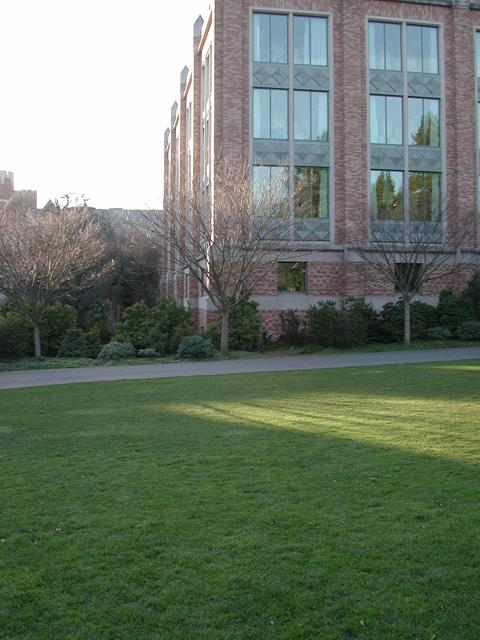

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2

from google.colab.patches import cv2_imshow



img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/CSE620/campus_001.jpg")


cv2_imshow(img)

# 1. Extract features from two images

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
#img1 = cv.imread('/content/drive/MyDrive/Colab Notebooks/CSE620/campus_000.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
#img2 = cv.imread('/content/drive/MyDrive/Colab Notebooks/CSE620/campus_001.jpg',cv.IMREAD_GRAYSCALE) # trainImage

def extractFeatures(img1, img2, verbose=False): 
  # Initiate SIFT detector
  sift = cv.SIFT_create()
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  # BFMatcher with default params
  bf = cv.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
  # cv.drawMatchesKnn expects list of lists as matches.
  if (verbose):
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()
  return kp1, kp2, good

AP = 0

A = matrix

P = vector

SVD decomposition

# 2. Implement the SVD-based algorithm to calculate the H matrix with 4 points.

In [ ]:
from PIL.Image import LANCZOS
import numpy as np

'''
p1: source pts
p2: destination pts
'''
#====DLT method calculate the H matrix====#
def calculateH(p1, p2):
  A = []
  for i in range(len(p1)):
    x, y = p1[i][0], p1[i][1]
    u, v = p2[i][0], p2[i][1]
    A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
    A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
  A = np.asarray(A)
  U, S, Vh = np.linalg.svd(A)
  L = Vh[-1, :] / Vh[-1, -1]
  H = L.reshape(3, 3)
  return H

'''
p1: source pt
p2: destination pt
unknown: fitted homography model
'''
def predict(src_pts, dst_pts, unknown):
  A = []
  x, y = src_pts[0], src_pts[1]
  u, v = dst_pts[0], dst_pts[1]
  A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
  A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
  A = np.asarray(A)
  h = unknown.reshape(9,1)
  expected = np.zeros(len(src_pts))
  actual = np.dot(A, h)
  return np.sum(np.square(expected - actual))

In [ ]:
def chain_rule(H, verbose=False):
  if (len(H) == 0):
    return np.identity(3)
  result = H[0]
  if (verbose):
    print(result)
  for homography in H[1:]:
    result = np.dot(result, homography)
    if (verbose):
      print(result)
  return result

In [ ]:
# good: vector of matches
# good[i]: vector of size 1, really we only want the first element

# Source: https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
def matchesToPts(matches):
  list_kp1 = np.float32([kp1[mat.queryIdx].pt for mat in matches])
  list_kp2 = np.float32([kp2[mat.trainIdx].pt for mat in matches])
  return list_kp1, list_kp2

# 3. Implement and use the RANSAC algorithm to eliminate the impact by the outliers. 

# 4. Find the best H matrix calculated with the best inlier matched points.

In [ ]:
import random
'''
points: points to be passed
s: number of random points to pick
n: number of iterations to run ransac
d: Threshold used to identify a point that fits well
t: the number of nearby points required to assert a model fits well
'''
# References:
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
def ransac(matches, s, n, d, t, verbose=False):
  # If matches is list of lists, convert to one list
  bestH = np.zeros((3, 3))
  maxInliers = 0
  if not isinstance(matches[0], cv.DMatch):
    matches = [mat[0] for mat in matches]

  best = 0
  for i in range(n):
    # Draw a sample of S points from the data uniformly and at random
    sample = random.sample(matches, s)
    src_pts, dst_pts = matchesToPts(sample)

    # Fit to that set of S points
    H = calculateH(src_pts, dst_pts)
    matchesMask = np.ones(len(sample))

    # For each data point outside the sample
    outside = [mat for mat in matches if mat not in sample]
    src_pts, dst_pts = matchesToPts(outside)

    inliers = 0
    for o in zip(src_pts, dst_pts):
      # Test the distance from the matches to the model
      dist = predict(o[0], o[1], H) # Find the euclidean distance/error rate of the point in the model
      if (dist <= d):
        inliers += 1
    if (verbose and i == n-1):
      print(f'inliers: {inliers}')
    # If there are t or more matched features close to the model
    if (inliers > t and inliers > maxInliers):
      # Refit the model using all points
      # src_pts, dst_pts = matchesToPts(matches)
      # bestH = calculateH(src_pts, dst_pts)
      bestH = H
      maxInliers = inliers
  # print(maxInliers)
  if (verbose):
    print(bestH)
    print(f'max Inliers: {maxInliers}')
  return bestH

# 5. Implement the final warping algorithm, test the nearest neighbor algorithm and the bilinear interpolation (weighted average solution).

In [ ]:
def plotBox(pts):
  x = []
  y = []

  for t in pts:
    x.append(t[0])
    y.append(t[1])

  x.append(pts[0][0])
  y.append(pts[0][1])

  plt.figure(figsize=(7.5, 15))
  plt.gca().invert_yaxis()
  plt.ylim(ymax=0, ymin=960)
  plt.xlim(xmin=0, xmax=1280)
  plt.plot(x, y, '-o')
  plt.show()

In [ ]:
def warp(f, H, img, method='backward', pixelMethod='bi'):
  # bi: bilinear interpolation
  # nn: Nearest neighbor
  # img is the total image to add f to
  # Method can be 'forward' or 'backward'

  if method == 'forward':
    for y in range(0, f.shape[0]):
      for x in range(0,f.shape[1]):
        src = np.array([[x],[y],[1]])
        dst = (np.dot(H, src).flatten())
        dst = np.round(np.divide(dst, dst[2])).astype(int) # Normalizes x and y
        if (dst[1] >= 0 and dst[0] >= 0):
          img[dst[1]][dst[0]] = f[y][x]
  elif method == 'backward':
    # Get bounding box
    # (0, 0), (0, 640), (480, 640), (480, 0)
    box = np.array([(0, 0), (0, f.shape[0]), (f.shape[1], f.shape[0]), (f.shape[1], 0)])
    # plotBox(box)
    newBox = []
    for corner in box:
      src = np.array([[corner[0]], [corner[1]], [1]])
      dst = np.dot(H, src).flatten()
      dst = np.divide(dst, dst[2]).astype(int)
      # print(dst)
      newBox.append(dst[:-1])
    # plotBox(newBox)
    # Get "lowest and highest" points
    startingRow = newBox[np.argmin(newBox, axis=0)[1]][1]
    endingRow = newBox[np.argmax(newBox, axis=0)[1]][1]
    startingCol = newBox[np.argmin(newBox, axis=0)[0]][0]
    endingCol = newBox[np.argmax(newBox, axis=0)[0]][0]

    yMax = max(f.shape[0], endingRow, startingRow)
    xMax = max(f.shape[1], endingCol, startingCol)

    # Apply inverse homography to get pixels
    H_inv = np.linalg.inv(H)

    for y in range(max(0, startingRow), endingRow):
      for x in range(max(0, startingCol), endingCol):
        src = np.array([[x], [y], [1]])
        dst = np.dot(H_inv, src).flatten()

        # Nearest neighbor
        # dst = np.round(np.divide(dst, dst[2])).astype(int)

        # Bilinear interpolation
        dst = np.round(np.divide(dst, dst[2])).astype(int)
        i = dst[0]
        j = dst[1]

        if (dst[1] >= 0 and j+1 < f.shape[0]) and (dst[0] >= 0 and i+1 < f.shape[1]):
          # Nearest neighbor
          if (pixelMethod == 'nn'):
            img[y][x] = f[dst[1]][dst[0]]

          # Bilinear interpolation
          elif (pixelMethod == 'bi'):
            a = dst[0] - i
            b = dst[1] - j
            img[y][x] =  (1-a)*(1-b)*f[j][i]\
                        +(a)*(1-b)*f[j][i+1]\
                        +(1-a)*(b)*f[j+1][i]\
                        +(a)*(b)*f[j+1][i+1]
  return img.astype('uint8')
  #im_dst = cv.warpPerspective(f, h, size)

## Expected (with OpenCV)

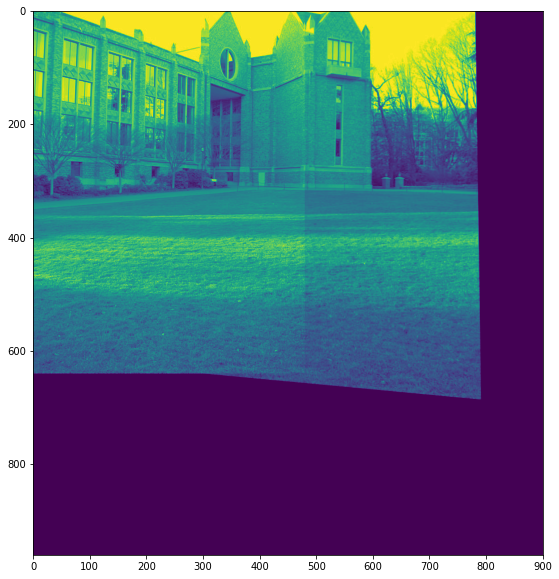

In [ ]:
result = cv.warpPerspective(srcImg, H, (width, height))
result[0:dstImg.shape[0], 0:dstImg.shape[1]] = dstImg
plt.figure(figsize=(20, 10))
plt.ylim(ymax=0, ymin=960)
plt.xlim(xmin=0, xmax=900)
plt.imshow(result)
plt.show()

## Forward Warping - 5 images

inliers: 2
[[ 8.61806622e-01  1.43583192e-02  2.60459919e+02]
 [-9.09676366e-02  9.68213080e-01  1.63188760e+01]
 [-2.87923161e-04  2.94807000e-06  1.00000000e+00]]
max Inliers: 333


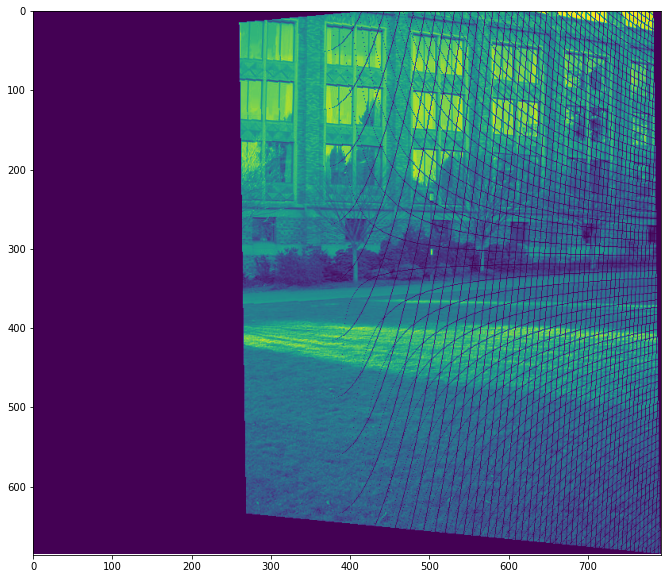

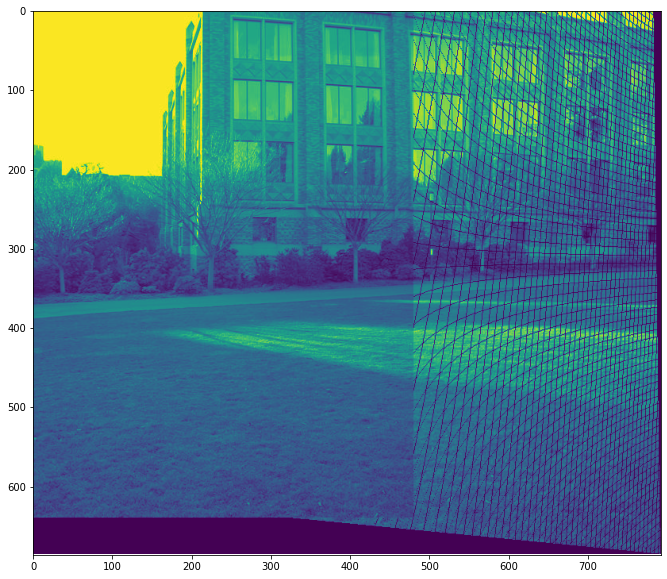

In [ ]:
from os import walk
from PIL import Image
from matplotlib import cm
# kp1, kp2, matches = extractFeatures(img1, img2, verbose=True)
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = next(walk("/content/drive/MyDrive/Colab Notebooks/CSE620"), (None, None, []))[2]
filenames.sort()
startIndex = 0
srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[startIndex]}',cv.IMREAD_GRAYSCALE)
stitches = []
homographies = []


# How many images do you want to stitch together?
numImages = 3

# Compute homography transformations between images
for i in range(startIndex, startIndex + numImages - 1, 1):
  if (len(filenames) == i or len(filenames) == i+1):
    break
  srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  dstImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i+1]}',cv.IMREAD_GRAYSCALE)
  kp1, kp2, matches = extractFeatures(srcImg, dstImg, verbose=False)
  width = srcImg.shape[1] + dstImg.shape[1]
  height = srcImg.shape[0] + dstImg.shape[0]
  H = ransac(matches, 4, 750, 10, 20, verbose=True)
  homographies.append(H)
  # g = warp(srcImg, H)
  # g[0:dstImg.shape[0], 0:dstImg.shape[1]] = dstImg
  # stitches.append(g.astype('uint8'))
  # srcImg = g.astype('uint8')
  #plt.imshow(g)
  #plt.show()

bounds = np.array([[dstImg.shape[1]], [dstImg.shape[0]], [1]])
chainH = chain_rule(homographies)
newBounds = np.dot(chainH, bounds)
# print(f'Max Homography: {chainH}')
# print (f'Original: {newBounds}')
# print(newBounds.dtype)
newBounds = np.ceil(np.divide(newBounds, newBounds[2])).astype(int)
newBounds = newBounds.flatten()
# print(newBounds.dtype)
# print (f'Panoramic image size: {newBounds}')
output = np.zeros((newBounds[1], newBounds[0]))

# Warp and stitch images
for i in range(startIndex, startIndex + numImages, 1):
  hImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  if (i == len(homographies)): # Last image, no warp
    chainH = np.identity(3)
  else:
    chainH = chain_rule(homographies[i-startIndex:], verbose=False)
  output = warp(hImg, chainH, output, method='forward')

  plt.figure(figsize=(20, 10))
  plt.ylim(ymax=0, ymin=newBounds[1])
  plt.xlim(xmin=0, xmax=newBounds[0])
  plt.imshow(output)
  plt.show()

im = Image.fromarray(output)
im.save("output.jpeg")

## Backward Warping (Nearest Neighbor) - 5 images

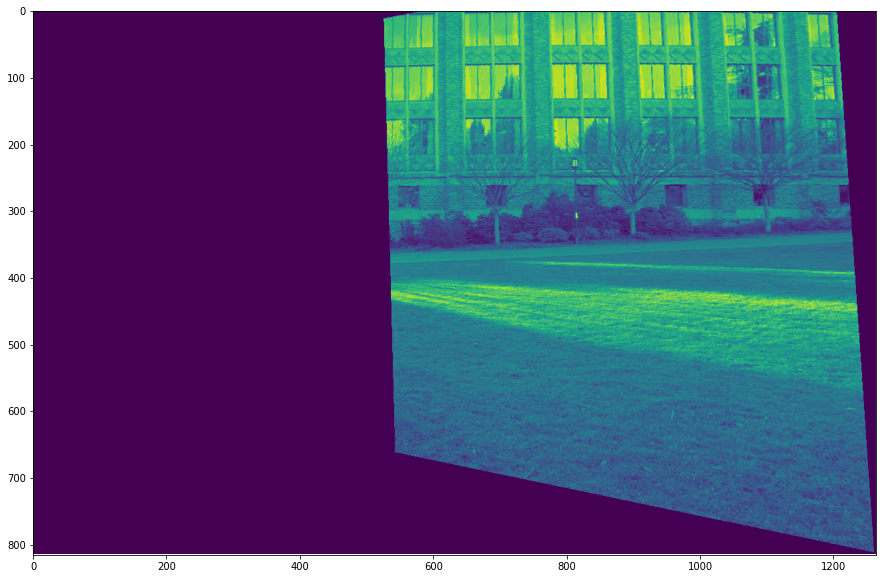

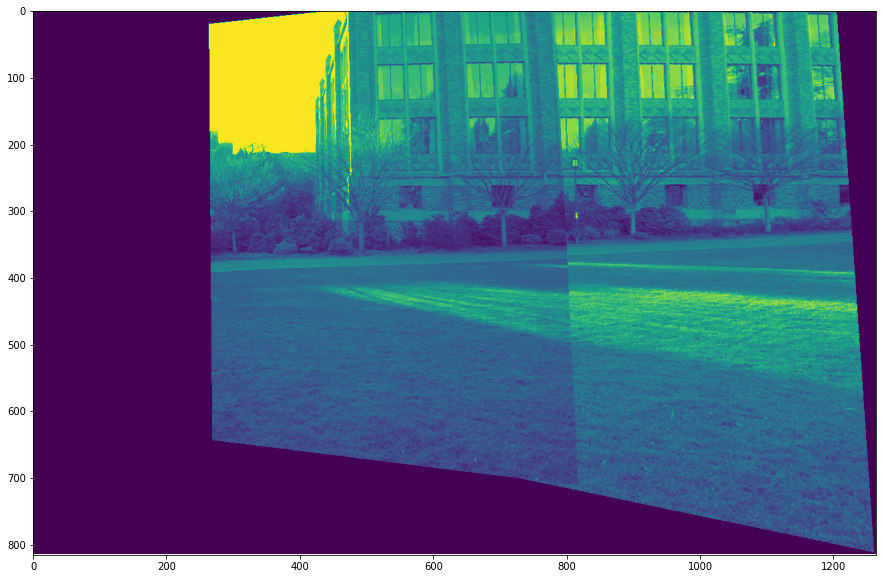

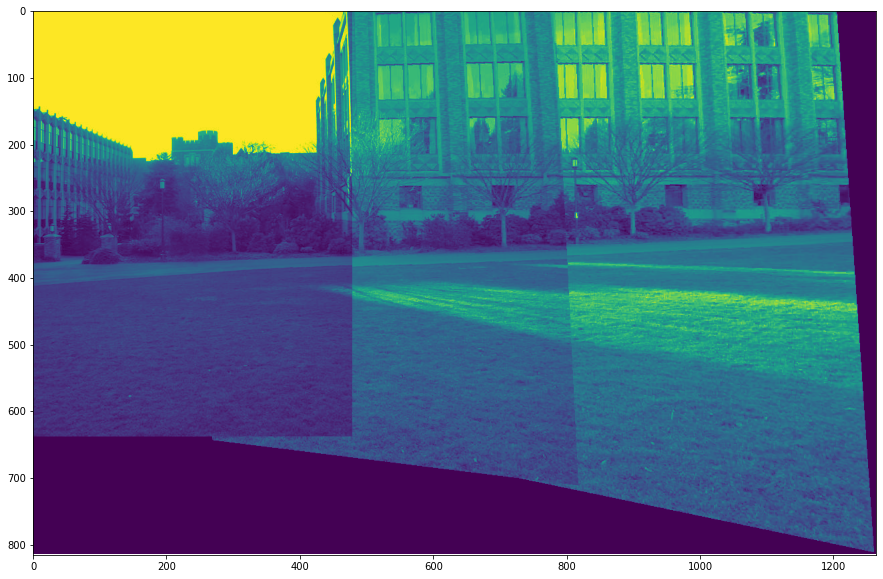

In [ ]:
from os import walk
from PIL import Image
from matplotlib import cm
# kp1, kp2, matches = extractFeatures(img1, img2, verbose=True)
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = next(walk("/content/drive/MyDrive/Colab Notebooks/CSE620"), (None, None, []))[2]
filenames.sort()

startIndex = 0
srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[startIndex]}',cv.IMREAD_GRAYSCALE)
stitches = []
homographies = []


# How many images do you want to stitch together?
numImages = 3

# Compute homography transformations between images
for i in range(startIndex, startIndex + numImages - 1, 1):
  if (len(filenames) == i or len(filenames) == i+1):
    break
  srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  dstImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i+1]}',cv.IMREAD_GRAYSCALE)
  kp1, kp2, matches = extractFeatures(srcImg, dstImg, verbose=False)
  width = srcImg.shape[1] + dstImg.shape[1]
  height = srcImg.shape[0] + dstImg.shape[0]
  H = ransac(matches, 4, 1000, 10, 20, verbose=False)
  homographies.append(H)
  # g = warp(srcImg, H)
  # g[0:dstImg.shape[0], 0:dstImg.shape[1]] = dstImg
  # stitches.append(g.astype('uint8'))
  # srcImg = g.astype('uint8')
  #plt.imshow(g)
  #plt.show()

bounds = np.array([[dstImg.shape[1]], [dstImg.shape[0]], [1]])
chainH = chain_rule(homographies)
newBounds = np.dot(chainH, bounds)
# print(f'Max Homography: {chainH}')
# print (f'Original: {newBounds}')
# print(newBounds.dtype)
newBounds = np.round(np.divide(newBounds, newBounds[2])).astype(int)
newBounds = newBounds.flatten()
# print(newBounds.dtype)
# print (f'Panoramic image size: {newBounds}')
output = np.zeros((newBounds[1], newBounds[0]))

# Warp and stitch images
for i in range(startIndex, startIndex + numImages, 1):
  hImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  if (i == len(homographies)): # Last image, no warp
    chainH = np.identity(3)
  else:
    chainH = chain_rule(homographies[i-startIndex:], verbose=False)
  output = warp(hImg, chainH, output, method='backward', pixelMethod='nn')

  plt.figure(figsize=(20, 10))
  plt.ylim(ymax=0, ymin=newBounds[1])
  plt.xlim(xmin=0, xmax=newBounds[0])
  plt.imshow(output)
  plt.show()

im = Image.fromarray(output)
im.save("output.jpeg")

## Backward Warping (Weighted Average) - 5 images

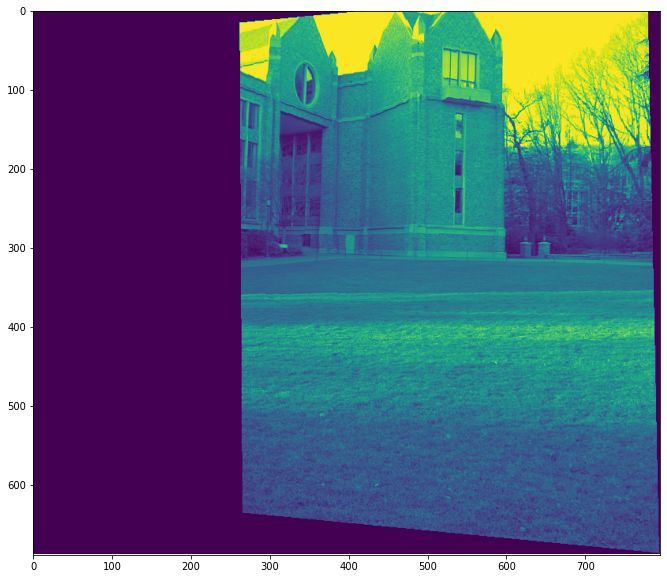

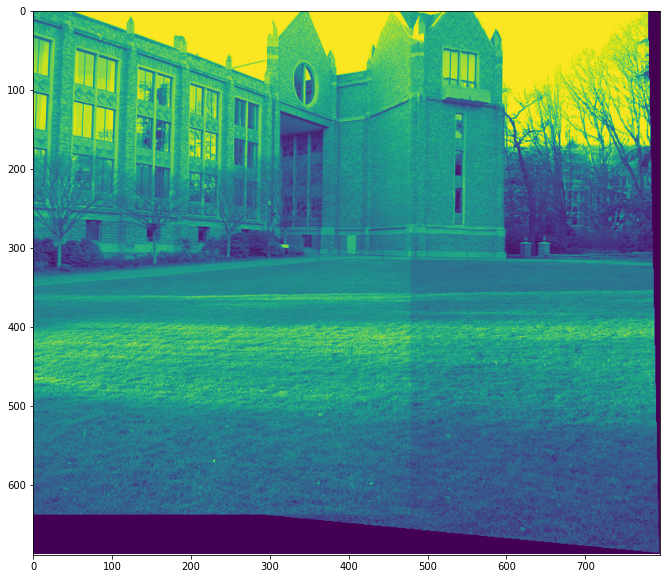

In [ ]:
from os import walk
from PIL import Image
from matplotlib import cm
# kp1, kp2, matches = extractFeatures(img1, img2, verbose=True)
# Source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
filenames = next(walk("/content/drive/MyDrive/Colab Notebooks/CSE620"), (None, None, []))[2]
filenames.sort()

startIndex = 16
srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[startIndex]}',cv.IMREAD_GRAYSCALE)
stitches = []
homographies = []


# How many images do you want to stitch together?
numImages = 2

# Compute homography transformations between images
for i in range(startIndex, startIndex + numImages - 1, 1):
  if (len(filenames) == i or len(filenames) == i+1):
    break
  srcImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  dstImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i+1]}',cv.IMREAD_GRAYSCALE)
  kp1, kp2, matches = extractFeatures(srcImg, dstImg, verbose=False)
  width = srcImg.shape[1] + dstImg.shape[1]
  height = srcImg.shape[0] + dstImg.shape[0]
  H = ransac(matches, 4, 1000, 10, 20, verbose=False)
  homographies.append(H)
  # g = warp(srcImg, H)
  # g[0:dstImg.shape[0], 0:dstImg.shape[1]] = dstImg
  # stitches.append(g.astype('uint8'))
  # srcImg = g.astype('uint8')
  #plt.imshow(g)
  #plt.show()

bounds = np.array([[dstImg.shape[1]], [dstImg.shape[0]], [1]])
chainH = chain_rule(homographies)
newBounds = np.dot(chainH, bounds)
# print(f'Max Homography: {chainH}')
# print (f'Original: {newBounds}')
# print(newBounds.dtype)
newBounds = np.round(np.divide(newBounds, newBounds[2])).astype(int)
newBounds = newBounds.flatten()
# print(newBounds.dtype)
# print (f'Panoramic image size: {newBounds}')
output = np.zeros((newBounds[1], newBounds[0]))

# Warp and stitch images
for i in range(startIndex, startIndex + numImages, 1):
  hImg = cv.imread(f'/content/drive/MyDrive/Colab Notebooks/CSE620/{filenames[i]}',cv.IMREAD_GRAYSCALE)
  if (i == len(homographies)): # Last image, no warp
    chainH = np.identity(3)
  else:
    chainH = chain_rule(homographies[i-startIndex:], verbose=False)
  output = warp(hImg, chainH, output, method='backward', pixelMethod='bi')

  plt.figure(figsize=(20, 10))
  plt.ylim(ymax=0, ymin=newBounds[1])
  plt.xlim(xmin=0, xmax=newBounds[0])
  plt.imshow(output)
  plt.show()

im = Image.fromarray(output)
im.save("output.jpeg")